## 実習の事前準備

In [1]:
# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を有効にする
sns.set_theme()

/Users/MisayoMacBookPro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


このレッスンでも、scikit-learnに含まれている Iris データセットを使用します。

In [2]:
# Irisデータセットの読み込み
from sklearn.datasets import load_iris
iris = load_iris()

以降で扱いやすいよう、DataFrame型へ変換しておきます。アヤメの品種は「species」という列名で追加しています。

In [3]:
# irisのfeature_namesは「sepal length(cm)」のように空白やカッコが付いていて扱いづらいので以下の列名を使用する
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# datasetの作成
dataset = pd.DataFrame(data = iris['data'], columns = feature_names)
dataset['species'] = iris['target']
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


クラスタリングとは、データをグループに分ける手法です。まずはデータセットの petal_width と petal_length で散布図を作成してみましょう。

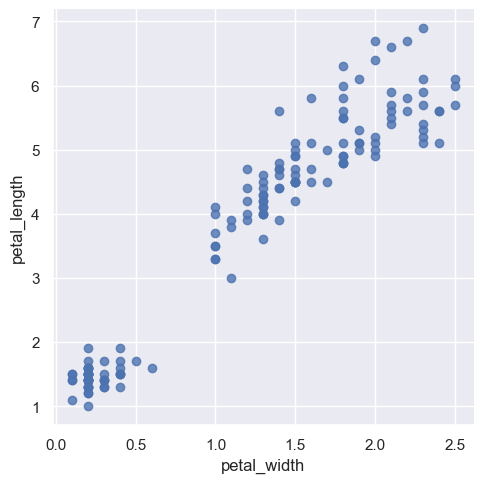

In [4]:
# petal_width と petal_length による散布図
sns.lmplot(x='petal_width', y='petal_length', data=dataset, fit_reg=False)

これを「3つ」に丸で囲ってなんとなくグループ化してみましょう（ここでは丸は割愛）

このグループ化をプログラムで行う手法が クラスタリング です。1つ1つのグループのことを クラスタ 、グループの数のことを クラスタ数 と呼びます。

## k-means法を使ってみよう

In [5]:
# KMeansのimport
from sklearn.cluster import KMeans

In [6]:
# データ（X）：petal_widthとpetal_length
X = np.array(dataset[['petal_width', 'petal_length']])

# 形状を確認
print("X=", X.shape)

X= (150, 2)


モデルを作成し fit() で学習を行うのはこれまでと同様です。パラメータの意味は以下のとおりです。

- n_clusters：クラスタの数
- init： k-means++でk-means++法、または randomでk-means法を指定
- n_init：異なるシードを使ってクラスタリングを繰り返す数


In [7]:
# クラスタ数を3としてモデルを作成
kmeans_model = KMeans(n_clusters=3, init='k-means++', n_init=10)
kmeans_model.fit(X)

KMeans(n_clusters=3, n_init=10)

predict() でクラスタ番号（予測値）を取得できます。 fit_predict で学習とクラスタ番号の取得をまとめて行うことも可能です。

In [8]:
# クラスタ番号（予測値）を取得
# （補足）kmeans_model.fit_predict(X)：fitとpredictをまとめて実施
Y_pred = kmeans_model.predict(X)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

クラスタリングの結果と、アヤメの品種を比較してみましょう。

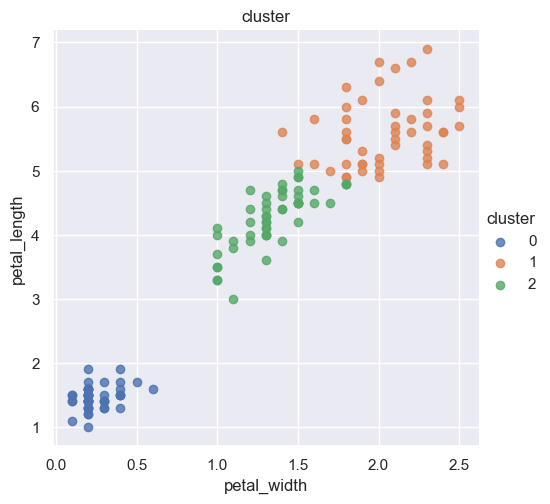

In [9]:
# グラフ化用DataFrameを作成して、tempに格納
temp = dataset[['petal_width', 'petal_length', 'species']].copy()
temp['cluster'] = kmeans_model.labels_

# k-means法によるクラスタリングの結果を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='cluster', fit_reg=False)
ax.set(title='cluster')

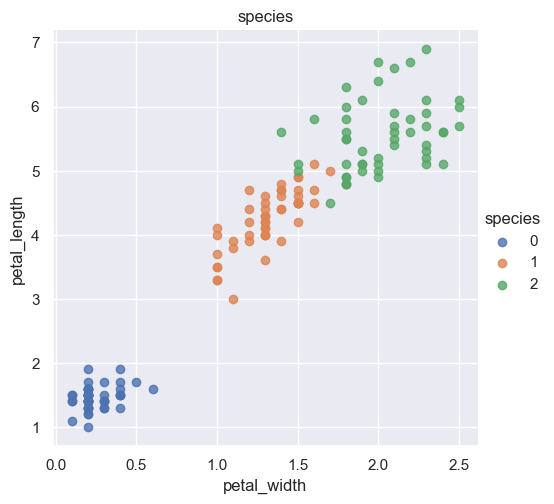

In [10]:
# アヤメの品種（正解）を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='species', fit_reg=False)
ax.set(title='species')

境目のところが若干違いますが、概ね、似たように分類されていることが確認できます。

## クラスタリングの評価

クラスタリングの評価基準には 凝集性（ぎょうしゅうせい、cohesion） と 分離性（ぶんりせい、separation） があります。

- 凝集性：各グループ内でデータの距離が近いこと。前述した WCSS（シードとデータとの距離の総和、Within-Cluster Sum of Squares）が小さいことを意味します
- 分離性：各クラスター同士が離れていること

### 凝集性（エルボーメソッドのグラフ）

はじめは 凝集性 に着目します。クラスタ数を変えながらWCSSをグラフで確認し、適切なクラスタ数を評価してみましょう。

モデルの inertia_ プロパティにWCSSが格納されています。

In [10]:
# 各クラスタごとのWCSSを格納するリスト
wcss = []

# クラスタ数のリスト（1から9)
c_list = np.arange(1, 10)

for c in c_list:
    # クラスタ数を c で指定
    kmeans_model = KMeans(n_clusters=c, init='k-means++', n_init=10)
    kmeans_model.fit(X)
    # inertia_プロパティに、WCSSが格納されている
    wcss.append(kmeans_model.inertia_)

In [11]:
# WCSSの表示
wcss

[550.8953333333333,
 86.39021984551397,
 31.371358974358973,
 19.477123363965468,
 13.98321314102564,
 11.036333877751728,
 9.185075914423741,
 7.769252747252748,
 6.532504162646108]

<Axes: >

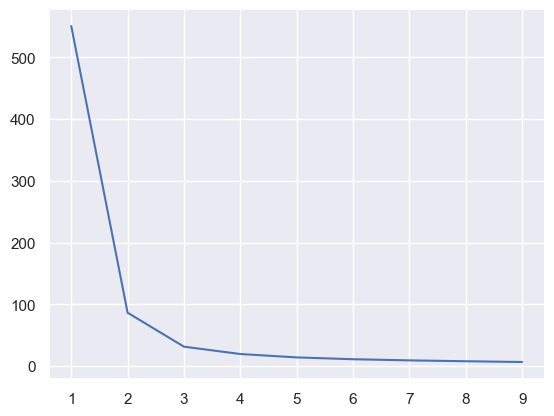

In [12]:
# グラフ化
sns.lineplot(x=c_list, y=wcss)

このグラフは肘のように見えることから エルボーメソッド (Elbow method)と呼ばれます。

- クラスタ数1～2：WCSSが大きい状態。十分にクラスタリングができていないことを示しています
- クラスタ数が5以上：クラスタ数を増やしても、WCSSの減少幅が小さくなります。このあたりから、クラスタ数を増やすことによる改善効果が薄れていると考えられます

よって、WCSSがこれ以上大きく下がらないクラスタ数3か4が「最適なクラスタ数」と読み取ることができます。

### 凝集性と分離性（シルエットプロットのグラフ）

凝集性と分離性の両方に着目したのが シルエットプロット です。シルエットプロットは シルエットスコア をグラフにしたものです。シルエットスコアは、クラスタに属するデータとシードとの距離を -1～1 の値の範囲で表したものです。1 に近いほど、自クラスタのシードに近く、-1 に近いほど、他のクラスタのシードに近い（自クラスタのシードからは遠い）と言えます。

シルエットスコアを計算するには scikit-learn の silhouette_score と silhouette_samples を使います。

In [43]:
# 必要なライブラリの追加import
from sklearn.metrics import silhouette_score, silhouette_samples

今回はクラスタ数＝3でクラスタリングを行ってみます。

In [44]:
# クラスタ数の指定
cluster_no = 3

# クラスタリング
kmeans_model = KMeans(n_clusters=cluster_no, init='k-means++', n_init=10)
Y_pred = kmeans_model.fit_predict(X)

シルエットスコアを計算します。

In [46]:
# シルエットスコアの平均値
s_average = silhouette_score(X, Y_pred)

# 各データのシルエットスコア
s_score = silhouette_samples(X, Y_pred, metric='euclidean')

参考サイトのソースコードを少し改修してシルエットプロットを描画します。ソースコードの内容は理解する必要がありません。
参照サイト：
　https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
　https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html
　https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

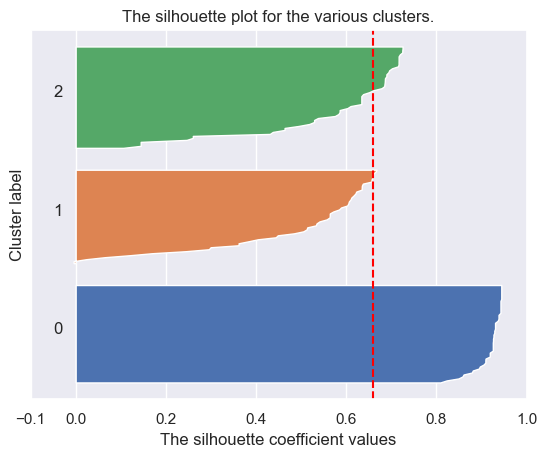

In [48]:
# シルエットプロットを描画
# 参考： https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
y_lower = 0

for i in range(cluster_no):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = s_score[Y_pred == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    #color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=s_average, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

シルエットプロットは、シルエットスコアを横線で引いたものです。それぞれのナイフのような形は、各データのシルエットスコアの横線が集まったものです。このシルエットプロットから以下のようなことを判断します。

- 各シルエットがナイフのような形になっていれば、きれいにクラスタリングが行われていると判断できます
- クラスタ番号0のデータは、シルエットスコアが概ね1に近く、高い凝集性であることがわかります
- 各シルエットの厚さが同等であれば、各クラスタのデータ数も同等と判断できます
- クラスタ番号1をよく見ると、ごくわずかですがスコアがマイナスになっているデータがあります。このぐらいであれば問題ありませんが、マイナスが多いようであれば、クラスタ数の変更が必要と判断します

クラスタ数をいろいろと変えて、シルエットプロットの変化を確認してみましょう。

## 補足

### 混合ガウスモデル

In [18]:
# GaussianMixtureのimport
from sklearn.mixture import GaussianMixture

In [19]:
# クラスタ数を3として混合ガウスモデルを作成
gaussian_model = GaussianMixture(n_components=3, n_init=10)
gaussian_model.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [20]:
# クラスタ番号を取得
Y_pred = gaussian_model.predict(X)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

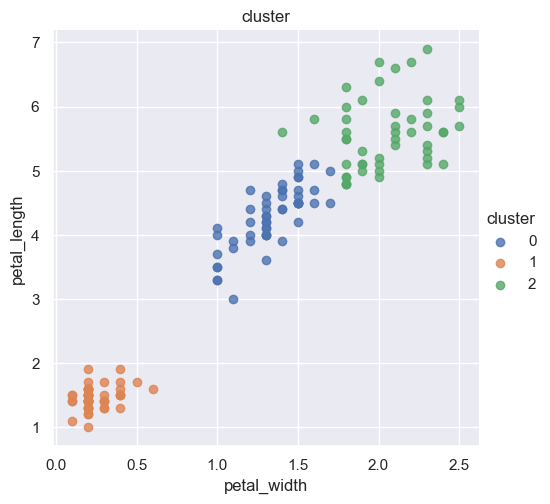

In [21]:
# グラフ化用DataFrameの作成
temp = dataset[['petal_width', 'petal_length', 'species']].copy()
temp['cluster'] = Y_pred

# 混合ガウスモデルによるクラスタリングの結果を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='cluster', fit_reg=False)
ax.set(title='cluster')

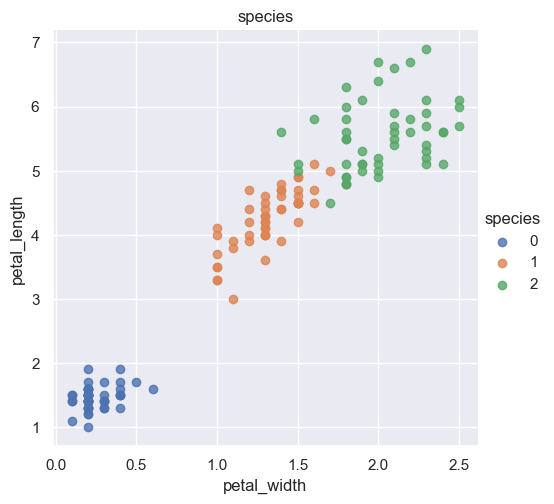

In [22]:
# アヤメの品種を描画
ax = sns.lmplot(x='petal_width', y='petal_length', data=temp, hue='species', fit_reg=False)
ax.set(title='species')

### 階層型クラスタリング

In [23]:
# 必要なライブラリの追加import
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

In [24]:
# 総当り距離の計算
dists = pdist(X)
dists.shape

(11175,)

In [25]:
# 150 X 150 の行列の形に変換
dists2 = squareform(dists)
dists2.shape

(150, 150)

<Axes: >

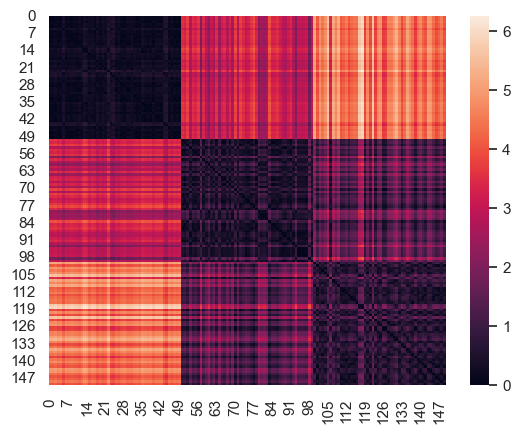

In [26]:
# ヒートマップによる可視化
sns.heatmap(dists2)

In [27]:
# 階層型クラスタリングの実行
Z = linkage(dists, 'ward')

In [28]:
# 0番目の組み合わせ
Z[0]

array([0., 1., 0., 2.])

In [29]:
# ノード番号の確認1
Z[:,0]

array([  0.,   4.,   2.,   3.,   8.,   6.,  10.,  28.,   9.,  27.,  11.,
        12.,  14.,  15.,  40.,  45.,  38.,  42.,  29.,  30.,  46.,  34.,
        39.,  48.,  31.,  33.,  47.,  49.,  57.,  60.,  53.,  89.,  88.,
        94.,  74.,  65.,  51.,  68.,  78.,  84.,  50.,  52.,  70., 138.,
       123., 101., 116., 136.,  55.,  62., 119., 110., 115., 112., 100.,
         5.,  69.,  58.,  85.,  18.,  56., 114.,  76., 146., 103.,  16.,
        95.,  19.,  92.,  54., 149.,  23.,  90.,  83., 132.,  80., 104.,
       125., 111.,  13., 158., 105., 193., 184., 162., 144., 182., 124.,
       121., 148., 165., 122., 143., 170., 108.,  24.,  73., 185.,  77.,
        43., 107.,  81.,  59., 102., 135., 210., 139., 173., 208., 220.,
       177., 191.,  61., 211., 234., 199., 246., 217.,  98.,  64., 118.,
       227., 247., 237., 134., 243., 229., 256., 252., 235., 258., 267.,
       232., 268., 250., 260., 254., 263., 272., 274., 281., 282., 278.,
       286., 270., 288., 291., 295., 290.])

In [30]:
# ノード番号の確認2
Z[:,1]

array([  1., 150.,  36.,   7., 151.,  17., 153., 154.,  32., 156.,  25.,
        37.,  35.,  21.,  41., 155., 152., 166., 160., 168., 169., 159.,
       171., 172., 163., 157., 175., 176.,  93.,  79.,  71., 180.,  99.,
        96.,  97.,  75.,  66., 186., 187., 188.,  63.,  72., 126., 192.,
       127., 142., 137., 140.,  87.,  67., 133., 113., 145., 128., 109.,
        26.,  82.,  91., 106.,  20.,  86., 141., 190., 195., 196., 164.,
       183., 174., 181., 189., 213., 205., 198., 200., 203., 206., 120.,
       130., 147.,  22., 161., 117., 194., 216., 167., 197., 218., 224.,
       201., 202., 215., 231., 226., 209., 129.,  44., 207., 222., 223.,
       221., 131., 179., 236., 242., 204., 212., 228., 230., 219., 238.,
       257., 248., 233., 239., 240., 225., 255., 249., 178., 251., 241.,
       244., 262., 253., 214., 245., 264., 259., 265., 273., 266., 275.,
       261., 269., 271., 276., 279., 277., 280., 284., 285., 287., 283.,
       289., 293., 292., 294., 296., 297.])

In [31]:
# ノード番号が150以上となる組み合わせの例
Z[108]

array([208.        , 219.        ,   0.26140645,   8.        ])

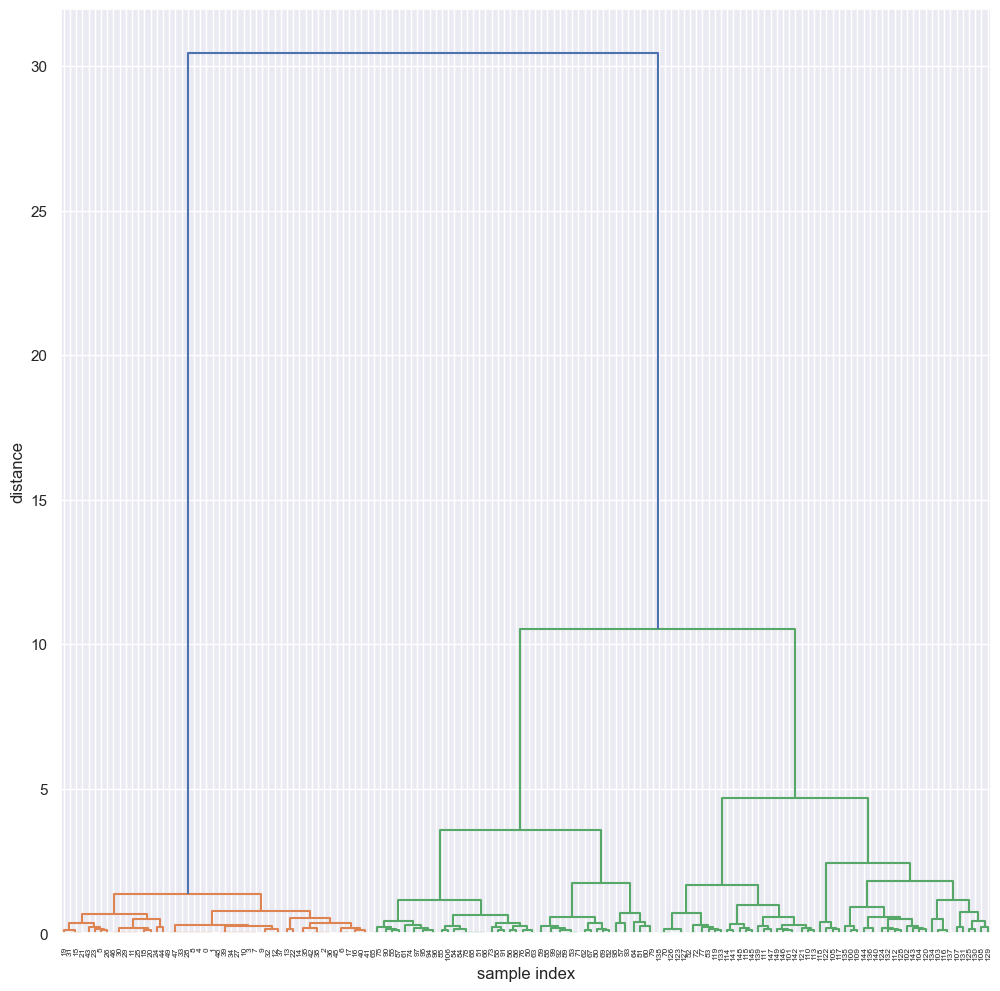

In [32]:
# グラフの大きさを指定
fig = plt.figure(figsize=(12, 12))

# X軸とY軸のラベルを指定
plt.xlabel('sample index')
plt.ylabel('distance')

# デンドログラムの作成
dendrogram(
    Z,
    leaf_rotation=90.,  # X軸のラベルを90度回転させる
    leaf_font_size=6.,  # X軸のラベルのフォントサイズを指定
)
plt.show()